<a href="https://colab.research.google.com/github/FGKCV/LOWESS/blob/main/LOWESS_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Intuição

O LOWESS, ou Locally Weighted Scatterplot Smoothing, é um algoritmo de regressão que calcula, para cada ponto, uma regressão linear com pesos móveis (ou seja, para cada ponto temos um peso associado diferente) para o cálculo do valor no ponto.

A seguinte animação ilustra o funcionamento do algoritmo:









In [44]:
from base64 import b64encode
mp4 = open('animacao.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Na animação acima, representamos em azul os dados rotulados enquanto que a curva preta indica a regressão obtida através do LOWESS.

Usualmente, para o cálculo de cada ponto da regressão utilizamos apenas os dados mais próximos ao ponto. Na animação exemplificamos este princípio através dos pontos em verde claro. Separamos os dados que são utilizados para encontrar a regressão linear ponderada naquela vizinhança fazendo uso do vizinho mais próximo. Neste processo, a ponderação dos pesos na regressão é inversamente proporcional à distância dos dados ao ponto em questão. Isto é, atribuímos peso maior aos dados mais próximos do ponto e um peso menor para os dados mais distantes.

No caso da animação, estamos utilizando pesos dados por uma tricúbica, em que fazemos a regressão linear para uma reta, sendo a reta representada em cima de cada ponto na animação, mas poderíamos, também, utilizar outras funções peso e regressões lineares para polinômios de qualquer grau.

# Formulação Matemática

O LOWESS possui muitas formulações distintas, mas todas seguem o mesmo princípio. O algorítmo segue basicamente da seguinte estrutura:

*   Associamos a cada ponto $p$ não rotulado a ser previsto uma função peso $w_p$ satisfazendo algumas propriedades, que associa a cada ponto no conjunto de dados rotulados um valor real não negativo.
*   Criamos um modelo associado a cada ponto $p$ utilizando uma regressão linear ponderada (possivelmente polinomial, incluindo grau zero) treinada com os dados rotulados junto da função peso $w_p$.
*   Com isto, prevemos o valor de cada ponto $p$ como o valor de $p$ previsto pelo modelo associado a este ponto.

Pelas próximas subseções, teremos que $X = \{x_1, \cdots, x_n\} \subseteq \mathbb{R}$ é uma amostra rotulada pelos valores em $Y = \{y_1, \cdots, y_n\}  \subseteq \mathbb{R}$, e que $p \in \mathbb{R}$ é um ponto qualquer cujo valor será inferido pelo modelo.

## Pesos

No primeiro passo acima, associemos $p$ a uma função peso $w_p$ satisfazendo algumas propriedades. No caso, $w_p$ é uma função com domínio $\mathbb{R}$, ou apenas $X$, e com contradomínio $\mathbb{R}$. Pedimos as seguintes propriedades desta função:

Pedimos que $w_p$ seja não-negativa, ou seja, que $w_p(x) \geq 0$ para todo $x$, já que não se utiliza pesos negativos.

Queremos que a função seja simétrica com relação a $p$, ou seja, que $w_p(p+h) = w_p(p - h)$ para todo vetor $h \in \mathbb{R}$, para não dar preferência a qualquer lado do ponto.

E pedimos que $w_p$ não seja uma função crescente para $x \geq p$, para que demos preferência maior para pontos mais próximos de $p$, já que, é claro, utilizaremos $w_p$ para prever $p$.

Algumas instâncias de códigos de LOWESS, ainda mais, pedem que esta função peso dependa de um parâmetro $s$, com $\frac{1}{n} < s \leq 1$, fixado no inicio do algorítmo, para que encontremos os $\text{floor}(s\cdot n)$ pontos mais próximos de $p$ na amostra, e tenhamos que a função peso seja nula nos outros pontos da amostra. Isto é útil pois neste caso podemos ignorar estes pontos da amostra na modelagem da regressão linear correspondente a $p$, que acelera o algoritmo.

No caso em que estamos fazendo uma regressão linear polinomial em cada ponto, pedimos que $s > \frac{d+1}{n}$, em que $d$ é o grau da regressão, para que hajam pontos o suficiente para o funcionamento da regressão.

No caso, um valor de $s$ pequeno tende a aumentar a variância, enquanto um valor de $s$ grande tende a aumentar o bias no nosso modelo.

Utilizar uma função peso suave num algoritmo LOWESS usualmente traçará um modelo suave, enquanto uma função peso descontínua pode trazer descontinuidades no modelo.



## Regressão Linear Ponderada

Uma regressão linear ponderada é uma forma de regressão linear que utiliza de pesos associados a cada ponto no conjunto de treinamento, para que o polinômio obtido tenda mais a se ajustar aos dados com peso maior associado.

No caso do algoritmo que estamos descrevendo, o peso associado a cada ponto $x$ em $X$ para treinamento do modelo associado a $p$ será o valor $w_p(x)$.

## Regressão Robusta

Alguns modelos utilizam um passo adicional de regressão robusta, em que é feito um processo iterativo de múltiplos treinamentos de modelos de regressão linear ponderada, em que os pesos são atualizados em cada iteração.

O modelo descrito no capítulo 8 do livro "Statistical Models in S" de Chambers J.M. e Hastie T. utiliza de uma função peso biquadrática junto dos resíduos da previsão do modelo nos dados da amostra em cada iteração e o peso inicial, que é utilizada uma tricúbica, para o cálculo do peso a ser utilizado na próxima iteração.

# Hipóteses:

Para uma boa estimativa dos erros, pede-se estes sejam independentes entre si e estejam numa distribuição normal com a mesma variância.

Caso os erros não estejam normalizados, mas satisfaçam as outras hipóteses, há também como os estimar bem caso utilizemos da regressão robusta.

# Prós e Contras

Prós:

*   Não depende de que a função a ser modelada seja algum tipo de função específico.
*   É um método bastante flexível.
*   Não é muito difícil de se interpretar.
*   Pode se usar da teoria da regressão linear para se computar estimativas para os erros de generalização.


Contras:

*   É um método lento para fazer muitas computações, já que criamos um modelo para cada ponto.
*   Outliers podem afetar bastante o método (mas a estimativa robusta ajuda nisto!).
*   Pedimos que haja uma quantidade grande e densa de dados para que o modelo os represente bem.
*   O método não retorna uma função dada por uma fórmula simples de ser compreendida e aplicada no papel.






# Os Códigos

## Algumas funções peso

Seguem algumas funções peso para aplicação no algoritmo do LOWESS, junto de uma função para encontrar os vizinhos mais próximos, caso necessário.

In [45]:
from sklearn.neighbors import NearestNeighbors

def vizin(ponto,x,s):
  n = len(x)
  kneigh = m.floor(n*s)
  knn = NearestNeighbors(n_neighbors=kneigh)
  knn.fit(x)
  dist, vizinhos = knn.kneighbors(np.asarray([ponto]).reshape(-1, 1))
  d = np.amax(dist)
  return dist,vizinhos

def tricubica(ponto, x, s):
  n = len(x)
  dist,vizinhos = vizin(ponto,x,s)
  d = np.amax(dist)
  pesos = np.zeros(n)
  for i in range(len(vizinhos[0])):
    di = dist[0][i]
    pesos[vizinhos[0][i]] = (1 - (di/d)**3)**3
  return pesos

def ones(ponto,x,s):
  n = len(x)
  dist,vizinhos = vizin(ponto,x,s)
  pesos = np.zeros(n)
  for viz in vizinhos[0]:
    pesos[viz] = 1
  return pesos

def normal(ponto,x,s):

  n = len(x)
  pesos = np.zeros(n)
  for i in range(n):
    pesos[i] = np.exp(-(np.inner(x[i] - ponto, x[i] - ponto))/(2*s**2))
  return pesos

## O algoritmo

Segue o algoritmo para o LOWESS que escrevi, utilizando a regressão linear do sklearn, em que podemos escolher o coeficiente de suavidade, o grau da regressão linear polinomial e a função peso, e que devolve o valor previsto para o ponto escolhido, dada uma amostra $x$ associada aos valores $y$.

No caso, deixo como padrão o valor $s = 0.3$, a função peso tricúbica e o grau 1.

In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from statistics import median

def LOWESS(x,y,ponto,s=0.3,deg=1,peso=tricubica):
  x = x.reshape(-1,1)
  ponto = np.asarray([ponto]).reshape(-1, 1)
  w = peso(ponto,x,s)

  poly = PolynomialFeatures(deg)
  x = poly.fit_transform(x)
  ponto = poly.fit_transform(ponto)

  LR = LinearRegression()
  LR.fit(x,y,w)
  return LR.predict(ponto)[0]

## Amostras de exemplo

Trago também algumas amostras rotuladas para testarmos em alguns métodos.

In [47]:
x = np.linspace(0, 2*m.pi, 300)
y = np.sin(x) + (np.random.normal(size=len(x)))/10
senomaior = [x,y]

x = np.delete(x, [i+200 for i in range(50)])
y = np.delete(y, [i+200 for i in range(50)])
senoburaco = [x,y]

x = np.linspace(0,2*m.pi,30)
y = np.sin(x) + (np.random.normal(size=len(x)))/10
senomenor = [x,y]

x = np.linspace(0,2*m.pi, 300)
y = 2*x + 1 + (np.random.normal(size=len(x)))
reta = [x,y]

x = np.append(senomenor[0],3*np.pi/2)
y = np.append(senomenor[1],0)
outlier = [x,y]

x = np.append(senomaior[0],3*np.pi/2)
y = np.append(senomaior[1],0)
outliermaior = [x,y]

# Exemplos

## Testando numa reta

Vemos que numa reta o algoritmo do LOWESS com os parâmetros base nos retorna valores bastantes similares com os obtidos pela regressão linear usual, como visto no gráfico abaixo, mas como o LOWESS age localmente, podemos ver que o modelo não esperava que uma reta seria o modelo ideal para estes dados, como vemos plotados abaixo, com a reta em verde sendo a reta obtida pela regressão linear, e a curva em vermelho sendo a curva obtida pelo LOWESS.

<function matplotlib.pyplot.savefig>

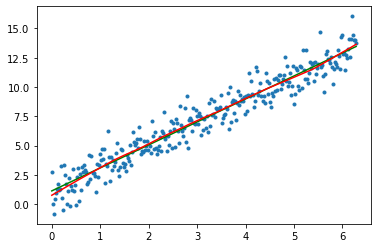

In [48]:
x,y = reta

x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x,LinearRegression().fit(x.reshape(-1,1),y).predict(x.reshape(-1,1)),'g')
plt.plot(x2,yLOW,'r')
plt.savefig

## Testando numa curva seno

Vemos que a curva gerada pelo LOWESS destes dados gerados por uma função seno é uma boa curva, com apenas, talvez, um pequeno deslocamento para cima no ponto de máximo, que ocorre pois ambos os lados deste ponto estão mais para baixo, o que acaba deslocando a reta associada ao ponto também para baixo, e o mesmo ocorre com o ponto de mínimo, sendo deslocado para cima.

<function matplotlib.pyplot.savefig>

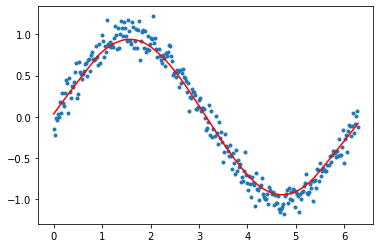

In [49]:
x,y = senomaior

x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

### Grau 2

Utilizando o grau 2, vemos acima que este problema de deslocamento dos pontos de máximo e mínimo é diminuido, já que a vizinhança destes pontos é melhor representada por uma parábola, apesar de a curva aparentar um pouco mais artificial, já que aumentar o grau acabou aumentando também a variância.

<function matplotlib.pyplot.savefig>

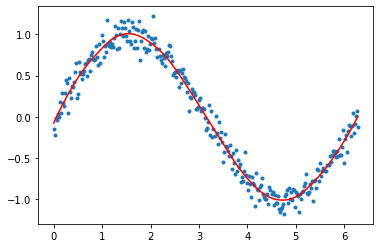

In [50]:
x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=2,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

### Parâmetro de suavização equeno

Para ilustrar os efeitos de um parâmetro de suavização pequena, é isto que ocorre quando pegamos vizinhanças muito próximas do ponto para sua previsão, que, como já mencionei ao falar do aumento da variância quando este é pequeno, o modelo acaba se sobreajustando.

<function matplotlib.pyplot.savefig>

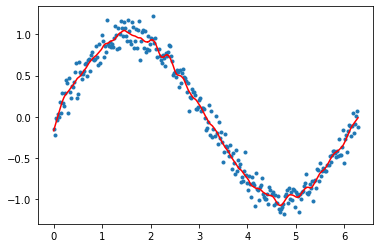

In [51]:
x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.05,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

### Parâmetro de suavização grande

E para ilustrar o aumento do bias com um parâmetro de suavização grande, isto é o que ocorre quando $s$ é alto, e pegamos seções muito grandes dos dados, tais que uma aproximação linear já não é mais ideal nelas.

<function matplotlib.pyplot.savefig>

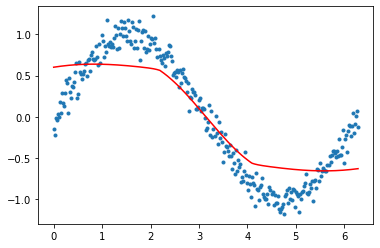

In [52]:
x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.7,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

### Peso ones

Apenas para ilustrar os outros pesos, este é a previsão do algoritmo utilizando o peso ones, que associa um peso 1 aos dados mais próximos, e um peso 0 aos dados mais longe. Note que o efeito mencionado perto dos pontos de máximo e mínimo é pior com este peso, e, além disto, a curva no centro da função está mais inclinada. É claro, este peso é um que inventei para fins de comparação, de modo que não é feito para ser perfeito.

<function matplotlib.pyplot.savefig>

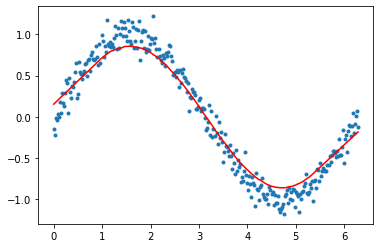

In [53]:
x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=ones) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

### Peso normal

O peso normal é um peso que encontrei sendo aplicado, que utiliza todos os dados, e não apenas os mais próximos, mas utilizamos o parâmetro de suavização como uma forma de mudar a curva normal associada a cada ponto. Vemos que os resultados, assim como na tricúbica, parecem bons.

<function matplotlib.pyplot.savefig>

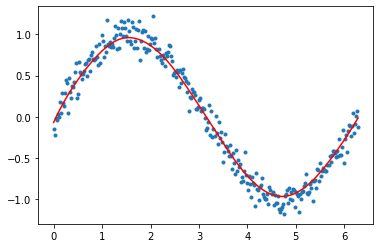

In [54]:
x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=normal) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

## Testando num conjunto com buraco

Nota-se que caso os dados possuam um buraco, o LOWESS não faz um trabalho muito bom em prever os pontos nele.

<function matplotlib.pyplot.savefig>

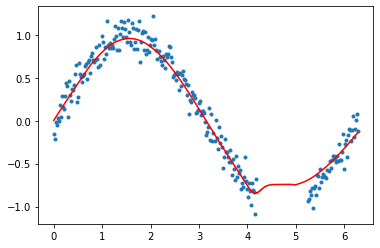

In [55]:
x,y = senoburaco

x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

## Testando num conjunto mais esparso

E se há poucos pontos, sem muito agrupamento, temos uma representação gráfica um tanto pior.

<function matplotlib.pyplot.savefig>

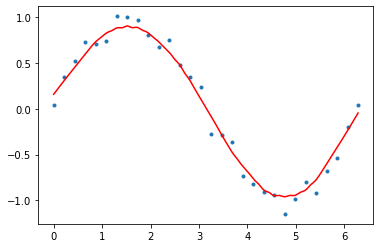

In [56]:
x,y = senomenor

x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

## Testando num conjunto com outlier

Vemos também que outliers acabam afetando bastante o modelo, especialmente num caso mais esparso, já que o cálculo de um ponto próximo de um outlier adicionará um peso maior a este outlier.

<function matplotlib.pyplot.savefig>

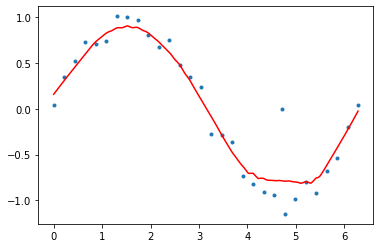

In [57]:
x,y = outlier

x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

## Testando num conjunto com outlier mais denso

Já num conjunto mais denso, ao menos, este efeito é mais controlado.

<function matplotlib.pyplot.savefig>

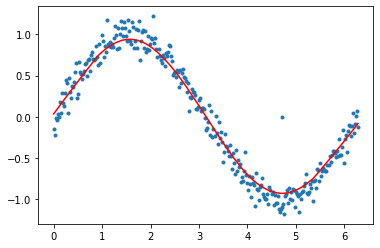

In [58]:
x,y = outliermaior

x2 = np.linspace(0, 2*m.pi, 800)
yLOW = [LOWESS(x,y,i,s=0.3,deg=1,peso=tricubica) for i in x2]

plt.plot(x,y,'.')
plt.plot(x2,yLOW,'r')
plt.savefig

# Apêndice

##Animação

Este é apenas o código que usei para fazer a animação no inicio deste notebook.

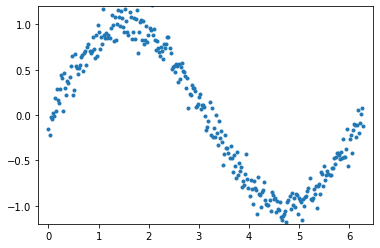

In [59]:
s1 = 0.3
deg1 = 1
peso1 = tricubica
x = senomaior[0]
y = senomaior[1]

x2 = np.linspace(0, 2*m.pi, 500)
yLOW = [LOWESS(x,y,i,s=s1,deg=deg1,peso=peso1) for i in x2]

def gif(x,y,ponto,s=0.3,deg=1,peso=tricubica):
  x = x.reshape(-1,1)
  
  indices = vizin(ponto,x,s1)[1]
  xvizin = np.asarray([x[j] for j in indices[0]])
  xvizin = xvizin.reshape(-1,1)

  ponto = np.asarray([ponto]).reshape(-1, 1)
  w = peso(ponto,x,s)

  poly = PolynomialFeatures(deg)
  x = poly.fit_transform(x)
  ponto = poly.fit_transform(ponto)
  xvizin = poly.fit_transform(xvizin)

  LR = LinearRegression()
  LR.fit(x,y,w)  
  return LR.predict(xvizin)

fig, ax = plt.subplots()
ax = plt.axes(xlim=(-0.2,2*m.pi+0.2), ylim=(-1.2, 1.2))
graph, = plt.plot(x,y,'.')
retagr, = plt.plot([],[])
vizinhança, = plt.plot([],[],'.c')
curva, = plt.plot([],[],'k')
ponto, = plt.plot([],[],'ok')



def animate(i):
  
  ponto.set_data(x2[i],LOWESS(x,y,x2[i],s=s1,deg=deg1,peso=peso1))
  curva.set_data(x2[:i],yLOW[:i])

  indices = vizin(x2[i],x.reshape(-1,1),s1)[1]
  vizins = [x[j] for j in indices[0]]

  retagr.set_data(vizins,gif(x,y,x2[i],s=s1,deg=deg1,peso=peso1))
  vizinhança.set_data(vizins,[y[j] for j in indices[0]])
  return graph, retagr, vizinhança, curva, ponto


#ani = FuncAnimation(fig, animate, repeat=False,frames=len(x2),interval=20)
#HTML(ani.to_html5_video())